In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("../results/data.csv")
index_new_exps = 4294
df = df.iloc[index_new_exps:]

df_newcol = df.set_axis(
    [
        "dataset",
        "foundational_model",
        "adapter",
        "n_features",
        "n_components",
        "is_fine_tuned",
        "pca_in_preprocessing",
        "use_revin",
        "context_length",
        "forecasting_horizon",
        "running_time",
        "seed",
        "metric",
        "value",
        "train_size",
    ],
    axis=1,
)
df_newcol

df_newcol.to_csv("../results/data_clean.csv", index=False)

In [3]:
df = pd.read_csv("../results/data_clean.csv")
df["adapter"] = df["adapter"].fillna("no_adapter")
df.head()

,dataset,foundational_model,adapter,n_features,n_components,is_fine_tuned,pca_in_preprocessing,use_revin,context_length,forecasting_horizon,running_time,seed,metric,value,train_size
0,Illness,AutonLab/MOMENT-1-small,linearAE,7,7,supervised,True,True,512.0,24,43.917139,20823.0,scaled_mse,3.927081,NaN
1,Illness,AutonLab/MOMENT-1-small,linearAE,7,7,supervised,True,True,512.0,24,43.917139,20823.0,scaled_mae,1.039715,NaN
2,Illness,AutonLab/MOMENT-1-small,linearAE,7,7,supervised,False,True,512.0,24,81.507269,26349.0,mse,4.060461,NaN
3,Illness,AutonLab/MOMENT-1-small,linearAE,7,7,supervised,False,True,512.0,24,81.507269,26349.0,mae,1.466816,NaN
4,Illness,AutonLab/MOMENT-1-small,linearAE,7,7,supervised,False,True,512.0,24,81.507269,26349.0,scaled_mse,4.010434,NaN


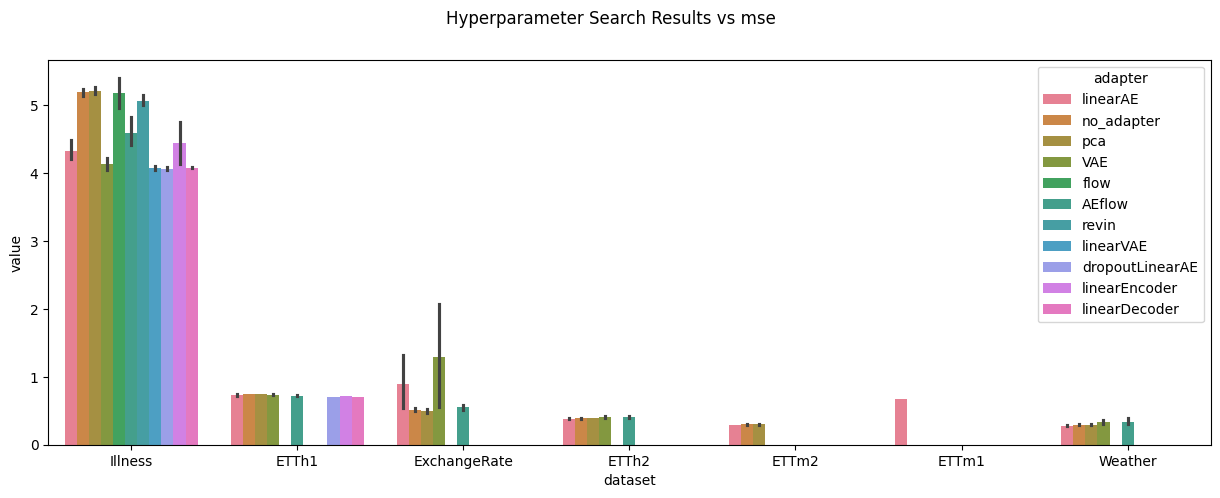

In [4]:
metric = "mse"

fig, axes = plt.subplots(1, 1, figsize=(15, 5))
# axes = axes.flatten()
fig.suptitle(f"Hyperparameter Search Results vs {metric}")

sns.barplot(
    df.loc[df["metric"] == metric], x="dataset", y="value", hue="adapter", ax=axes
)
plt.show()

In [5]:
def print_scores(
    dataset,
    adapter,
    forecasting_horizon,
    n_components,
    use_revin,
    pca_in_preprocessing,
    metric,
    train_size=None,
    is_fine_tuned="supervised",
):
    if train_size:
        df_ = df.loc[
            (df["dataset"] == dataset)
            & (df["adapter"] == adapter)
            & (df["n_components"] == n_components)
            & (df["use_revin"] == use_revin)
            & (df["pca_in_preprocessing"] == pca_in_preprocessing)
            & (df["metric"] == metric)
            & (df["forecasting_horizon"] == forecasting_horizon)
            & (df["train_size"] == train_size)
            & (df["is_fine_tuned"] == is_fine_tuned)
        ]
    else:
        df_ = df.loc[
            (df["dataset"] == dataset)
            & (df["adapter"] == adapter)
            & (df["n_components"] == n_components)
            & (df["use_revin"] == use_revin)
            & (df["pca_in_preprocessing"] == pca_in_preprocessing)
            & (df["metric"] == metric)
            & (df["forecasting_horizon"] == forecasting_horizon)
            & (df["is_fine_tuned"] == is_fine_tuned)
        ]
    print(
        f"Dataset: {dataset}, Adapter: {adapter}, n_components: {n_components}, use_revin: {use_revin}, pca_in_preprocessing: {pca_in_preprocessing}"
    )
    print(
        f"Mean: {df_['value'].mean()}, Std: {df_['value'].std()}, Standard Error: {df_['value'].sem()}"
    )
    print(f"Min: {df_['value'].min()}, Max: {df_['value'].max()}")
    print(
        f"25th percentile: {df_['value'].quantile(0.25)}, 75th percentile: {df_['value'].quantile(0.75)}"
    )
    print(f"Median: {df_['value'].median()}")
    print("Count of seeds: ", len(df_))
    print("\n")

In [6]:
dataset = "Illness"
adapter = "dropoutLinearAE"
n_components = 7
use_revin = True
pca_in_preprocessing = False
metric = "mse"
forecasting_horizon = 24
train_size = None
is_fine_tuned = "supervised"

print_scores(
    dataset,
    adapter,
    forecasting_horizon,
    n_components,
    use_revin,
    pca_in_preprocessing,
    metric,
    train_size,
    is_fine_tuned,
)

Dataset: Illness, Adapter: dropoutLinearAE, n_components: 7, use_revin: True, pca_in_preprocessing: False
Mean: 4.063665930219237, Std: 0.02189707566538523, Standard Error: 0.009792669939251562
Min: 4.039219209262008, Max: 4.098766966933774
25th percentile: 4.054744240963255, 75th percentile: 4.0646844525462384
Median: 4.060914781390911
Count of seeds:  5




### Barplot different Linear adapters

/tmp/ipykernel_2970695/1329886886.py:22: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.5}` instead.

  bar = sns.barplot(


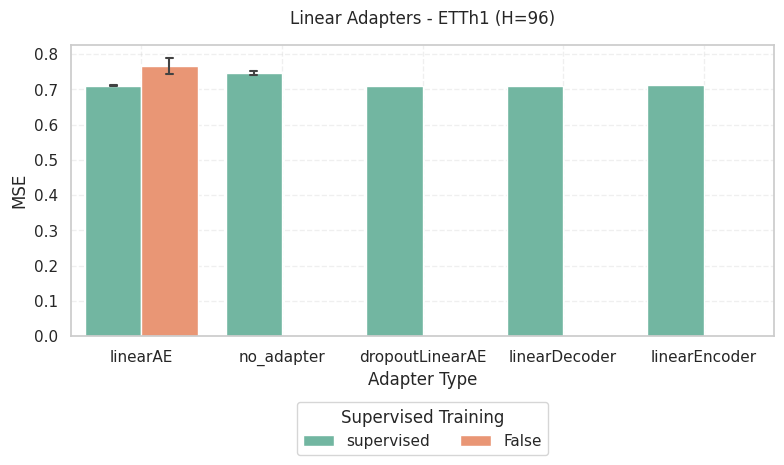

In [14]:
dataset = "ETTh1"
n_components = 7
use_revin = True
pca_in_preprocessing = False
metric = "mse"
forecasting_horizon = 96

df_ = df.loc[
    (df["dataset"] == dataset)
    & (df["adapter"].str.contains("inear") | (df["adapter"] == "no_adapter"))
    & (df["n_components"] == n_components)
    & (df["use_revin"] == use_revin)
    & (df["pca_in_preprocessing"] == pca_in_preprocessing)
    & (df["metric"] == metric)
    & (df["forecasting_horizon"] == forecasting_horizon)
]

plt.figure(figsize=(8, 5))
sns.set(style="whitegrid")

# Create barplot
bar = sns.barplot(
    data=df_,
    x="adapter",
    y="value",
    hue="is_fine_tuned",
    capsize=0.1,
    errwidth=1.5,
    palette="Set2",
)

# Customize plot
plt.title(f"Linear Adapters - {dataset} (H={forecasting_horizon})", pad=15)
plt.xlabel("Adapter Type", fontsize=12)
plt.ylabel("MSE", fontsize=12)
plt.legend(
    title="Supervised Training", bbox_to_anchor=(0.5, -0.2), loc="upper center", ncol=3
)

# Add grid and adjust layout
plt.grid(True, alpha=0.3, linestyle="--")
plt.tight_layout()

# # Save figure
# plt.savefig(
#     "/mnt/vdb/abenechehab/dicl-adapters/figures/from_notebooks/linear_adapters.pdf",
#     dpi=300,
#     bbox_inches="tight"
# )
plt.show()

## RevIn ablation

/tmp/ipykernel_2935138/1086297323.py:22: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.5}` instead.

  bar = sns.barplot(


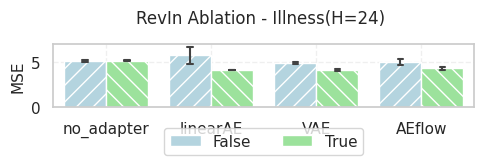

In [18]:
dataset = "Illness"
# adapter = "revin"
n_components = 7
# use_revin = False
pca_in_preprocessing = False
metric = "mse"
forecasting_horizon = 24

adapters_to_keep = ["no_adapter", "linearAE", "VAE", "AEflow"]

df_ = df.loc[
    (df["dataset"] == dataset)
    & (df["n_components"] == n_components)
    & (df["pca_in_preprocessing"] == pca_in_preprocessing)
    & (df["metric"] == metric)
    & (df["forecasting_horizon"] == forecasting_horizon)
    & (df["adapter"].isin(adapters_to_keep))
]

plt.figure(figsize=(5, 2))
sns.set(style="whitegrid", color_codes=True)
bar = sns.barplot(
    df_,
    x="adapter",
    y="value",
    hue="use_revin",
    order=adapters_to_keep,
    palette=sns.color_palette(["lightblue", "lightgreen"]),
    capsize=0.1,
    errwidth=1.5,
)

hatches = ["//", "\\\\"]
# Loop over the bars
for bars, hatch in zip(bar.containers, hatches):
    # Set a different hatch for each group of bars
    for bar in bars:
        bar.set_hatch(hatch)

# Add hatching pattern to the second hue category
# bars = plt.gca().patches
# n_bars = len(df_["adapter"].unique())
# for i in range(n_bars, len(bars)):
#     bars[i].set_hatch("///")
plt.title(f"RevIn Ablation - {dataset}(H={forecasting_horizon}) ", fontsize=12, pad=15)
plt.xlabel(None)
plt.ylabel("MSE", fontsize=11)
# plt.xticks(rotation=45)
plt.legend(title_fontsize=10, bbox_to_anchor=(0.5, -0.2), loc="upper center", ncol=3)
plt.grid(True, alpha=0.3, linestyle="--")
plt.savefig(
    "/mnt/vdb/abenechehab/dicl-adapters/figures/from_notebooks/revin_illness.pdf",
    dpi=300,
    bbox_inches="tight",
)
plt.tight_layout()

## Dimensionality reduction

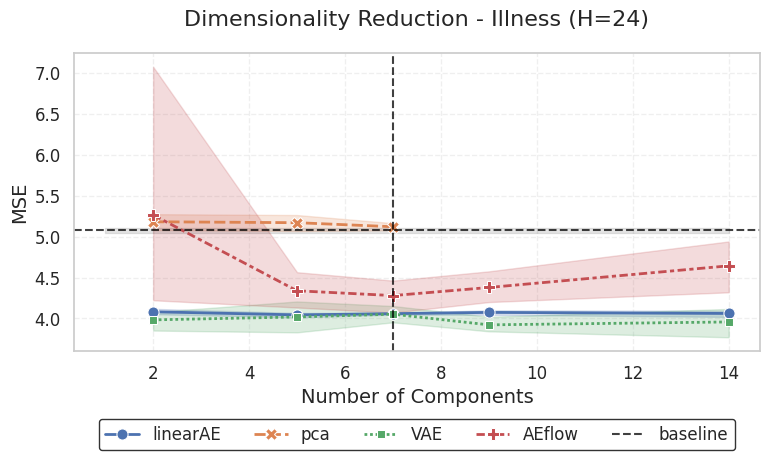

In [21]:
dataset = "Illness"
pca_in_preprocessing = False
metric = "mse"
forecasting_horizon = 24

# Filter data
df_ = df.loc[
    (df["dataset"] == dataset)
    & (df["pca_in_preprocessing"] == pca_in_preprocessing)
    & (df["metric"] == metric)
    & (df["forecasting_horizon"] == forecasting_horizon)
    & (
        (df["adapter"].isin(["linearAE", "VAE", "AEflow"]) & (df["use_revin"] == True))
        | (df["adapter"] == "pca")
    )
]

# Set style parameters
plt.rc("font", size=14)  # controls default text size
plt.rc("axes", titlesize=16)  # fontsize of the axes title
plt.rc("axes", labelsize=14)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=12)  # fontsize of the tick labels
plt.rc("ytick", labelsize=12)  # fontsize of the tick labels
plt.rc("legend", fontsize=12)  # fontsize of the legend

# Create figure
plt.figure(figsize=(8, 5))
sns.set_style("whitegrid")

# Plot main lines
bar = sns.lineplot(
    df_,
    x="n_components",
    y="value",
    hue="adapter",
    style="adapter",
    markers=True,
    markersize=8,
    linewidth=2,
)

# Add baseline
plt.axvline(x=7, color="black", linestyle="--", alpha=0.75, label="baseline")
bdf_ = df.loc[
    (df["dataset"] == dataset)
    & (df["pca_in_preprocessing"] == pca_in_preprocessing)
    & (df["metric"] == metric)
    & (df["forecasting_horizon"] == forecasting_horizon)
    & (df["adapter"] == "no_adapter")
    & (df["n_components"] == 7)
    & (df["use_revin"] == False)
]
values = bdf_["value"]
baseline = values.mean()
baseline_std = values.std()
plt.axhline(y=baseline, color="black", linestyle="--", alpha=0.75)
plt.fill_between(
    np.arange(1, 15),
    [baseline - baseline_std / np.sqrt(len(values))],
    [baseline + baseline_std / np.sqrt(len(values))],
    color="black",
    alpha=0.1,
)

# Customize plot
plt.title(f"Dimensionality Reduction - {dataset} (H={forecasting_horizon})", pad=20)
plt.xlabel("Number of Components", fontsize=14)
plt.ylabel("MSE", fontsize=14)
plt.legend(
    # title="Method",
    title_fontsize=12,
    bbox_to_anchor=(0.5, -0.2),
    loc="upper center",
    ncol=5,
    frameon=True,
    edgecolor="black",
)

# Customize grid
plt.grid(True, alpha=0.3, linestyle="--")

# Adjust layout and save
plt.tight_layout()
plt.savefig(
    "/mnt/vdb/abenechehab/dicl-adapters/figures/from_notebooks/n_comp.pdf",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

## Latent representation

In [9]:
from dicl.utils.main_script import prepare_data
from sklearn.decomposition import PCA

Illness_pred=24, size: (141, 7, 512), val size (74, 7, 512), test size (170, 7, 512)


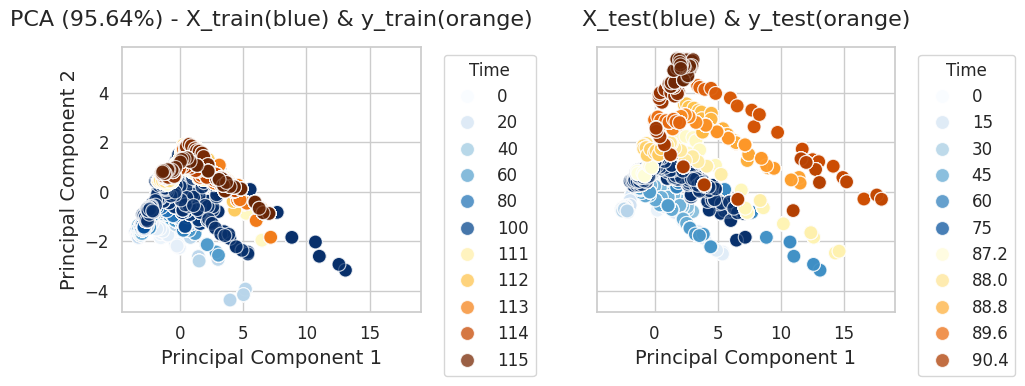

In [18]:
X_train, y_train, X_val, y_val, X_test, y_test, n_features = prepare_data(
    dataset_name="Illness_pred=24", context_length=512, forecasting_horizon=24
)
print(
    f"Illness_pred=24, size: {X_train.shape}, val size {X_val.shape}, test size {X_test.shape}"
)

X_train = (
    np.concatenate([X_train, X_val], axis=0).swapaxes(1, 2).reshape(-1, n_features)
)
y_train = (
    np.concatenate([y_train, y_val], axis=0).swapaxes(1, 2).reshape(-1, n_features)
)

X_test = X_test.swapaxes(1, 2).reshape(-1, n_features)
y_test = y_test.swapaxes(1, 2).reshape(-1, n_features)

# Apply PCA to X
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

y_pca = pca.transform(y_train)
X_test_pca = pca.transform(X_test)
y_test_pca = pca.transform(y_test)
# Compute the amount of explained variance by PCA
explained_variance = pca.explained_variance_ratio_

# Prepare data for plotting
X_pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
X_pca_df["time"] = np.arange(X_train.shape[0]) / 1000
y_pca_df = pd.DataFrame(y_pca, columns=["PC1", "PC2"])
y_pca_df["time"] = (
    np.arange(X_train.shape[0], X_train.shape[0] + y_train.shape[0]) / 1000
)

X_test_pca_df = pd.DataFrame(X_test_pca, columns=["PC1", "PC2"])
X_test_pca_df["time"] = np.arange(X_test.shape[0]) / 1000
y_test_pca_df = pd.DataFrame(y_test_pca, columns=["PC1", "PC2"])
y_test_pca_df["time"] = (
    np.arange(X_test.shape[0], X_test.shape[0] + y_test.shape[0]) / 1000
)

# Set style parameters for scientific paper
plt.rcParams.update(
    {
        "font.size": 14,
        "axes.titlesize": 16,
        "axes.labelsize": 14,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "legend.fontsize": 12,
    }
)

# Plot the first two principal components
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

# Plot X
sns.scatterplot(
    data=X_pca_df,
    x="PC1",
    y="PC2",
    hue="time",
    palette="Blues",
    alpha=0.75,
    s=100,
    ax=ax1,
)
sns.scatterplot(
    data=y_pca_df,
    x="PC1",
    y="PC2",
    hue="time",
    palette="YlOrBr",
    alpha=0.75,
    s=100,
    ax=ax1,
)
ax1.set_title(
    f"PCA ({sum(explained_variance)*100:.2f}%) - X_train(blue) & y_train(orange)",
    pad=15,
)
ax1.set_xlabel("Principal Component 1", fontsize=14)
ax1.set_ylabel("Principal Component 2", fontsize=14)
ax1.legend(title="Time", title_fontsize=12, bbox_to_anchor=(1.05, 1), loc="upper left")

# Plot X @ W_star
sns.scatterplot(
    data=X_test_pca_df,
    x="PC1",
    y="PC2",
    hue="time",
    palette="Blues",
    alpha=0.75,
    s=100,
    ax=ax2,
)
sns.scatterplot(
    data=y_test_pca_df,
    x="PC1",
    y="PC2",
    hue="time",
    palette="YlOrBr",
    alpha=0.75,
    s=100,
    ax=ax2,
)
ax2.set_title("X_test(blue) & y_test(orange)", pad=15)
ax2.set_xlabel("Principal Component 1", fontsize=14)
ax2.set_ylabel("Principal Component 2", fontsize=14)
ax2.legend(title="Time", title_fontsize=12, bbox_to_anchor=(1.05, 1), loc="upper left")

# Adjust layout
plt.tight_layout(w_pad=3)

# Save with high DPI
plt.savefig(
    "/mnt/vdb/abenechehab/dicl-adapters/figures/from_notebooks/pca_illness.pdf",
    dpi=300,
    bbox_inches="tight",
)
plt.savefig(
    "/mnt/vdb/abenechehab/dicl-adapters/figures/from_notebooks/pca_illness.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

In [14]:
import torch

/tmp/ipykernel_2888473/730006995.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  adapter = torch.load(adapter_path)


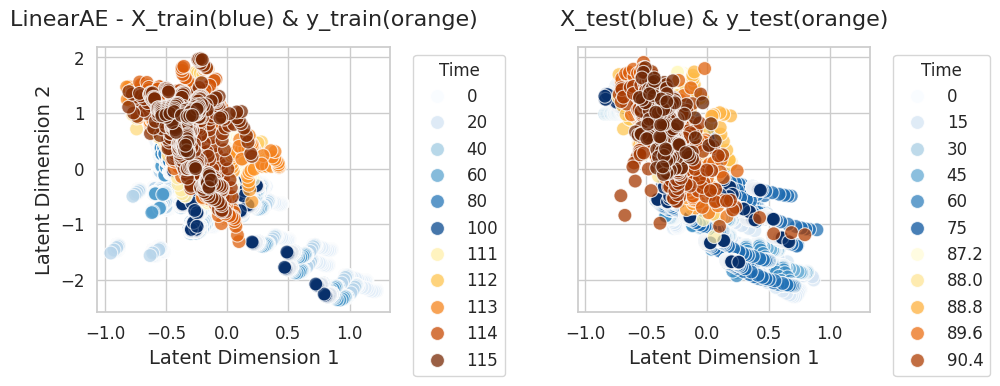

In [17]:
adapter_path = "../logs/logger/Illness_pred=24/20250121_195013_Illness_pred=24_linearAE_MOMENT-1-small/n_comp_2/adapter.pt"
adapter = torch.load(adapter_path)

# Apply PCA to X
X_pca = (
    adapter.transform_torch(torch.from_numpy(X_train).float().to("cuda:7"))
    .cpu()
    .detach()
    .numpy()
)
adapter.context_length = 24
y_pca = (
    adapter.transform_torch(torch.from_numpy(y_train).float().to("cuda:7"))
    .cpu()
    .detach()
    .numpy()
)
adapter.context_length = 512
X_test_pca = (
    adapter.transform_torch(torch.from_numpy(X_test).float().to("cuda:7"))
    .cpu()
    .detach()
    .numpy()
)
adapter.context_length = 24
y_test_pca = (
    adapter.transform_torch(torch.from_numpy(y_test).float().to("cuda:7"))
    .cpu()
    .detach()
    .numpy()
)

# Prepare data for plotting
X_pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
X_pca_df["time"] = np.arange(X_train.shape[0]) / 1000
y_pca_df = pd.DataFrame(y_pca, columns=["PC1", "PC2"])
y_pca_df["time"] = (
    np.arange(X_train.shape[0], X_train.shape[0] + y_train.shape[0]) / 1000
)

X_test_pca_df = pd.DataFrame(X_test_pca, columns=["PC1", "PC2"])
X_test_pca_df["time"] = np.arange(X_test.shape[0]) / 1000
y_test_pca_df = pd.DataFrame(y_test_pca, columns=["PC1", "PC2"])
y_test_pca_df["time"] = (
    np.arange(X_test.shape[0], X_test.shape[0] + y_test.shape[0]) / 1000
)

# Set style parameters for scientific paper
plt.rcParams.update(
    {
        "font.size": 14,
        "axes.titlesize": 16,
        "axes.labelsize": 14,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "legend.fontsize": 12,
    }
)

# Plot the first two principal components
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

# Plot X
sns.scatterplot(
    data=X_pca_df,
    x="PC1",
    y="PC2",
    hue="time",
    palette="Blues",
    alpha=0.75,
    s=100,
    ax=ax1,
)
sns.scatterplot(
    data=y_pca_df,
    x="PC1",
    y="PC2",
    hue="time",
    palette="YlOrBr",
    alpha=0.75,
    s=100,
    ax=ax1,
)
ax1.set_title(
    "LinearAE - X_train(blue) & y_train(orange)",
    pad=15,
)
ax1.set_xlabel("Latent Dimension 1", fontsize=14)
ax1.set_ylabel("Latent Dimension 2", fontsize=14)
ax1.legend(title="Time", title_fontsize=12, bbox_to_anchor=(1.05, 1), loc="upper left")

# Plot X @ W_star
sns.scatterplot(
    data=X_test_pca_df,
    x="PC1",
    y="PC2",
    hue="time",
    palette="Blues",
    alpha=0.75,
    s=100,
    ax=ax2,
)
sns.scatterplot(
    data=y_test_pca_df,
    x="PC1",
    y="PC2",
    hue="time",
    palette="YlOrBr",
    alpha=0.75,
    s=100,
    ax=ax2,
)
ax2.set_title("X_test(blue) & y_test(orange)", pad=15)
ax2.set_xlabel("Latent Dimension 1", fontsize=14)
ax2.set_ylabel("Latent Dimension 2", fontsize=14)
ax2.legend(title="Time", title_fontsize=12, bbox_to_anchor=(1.05, 1), loc="upper left")

# Adjust layout
plt.tight_layout(w_pad=3)

# Save with high DPI
plt.savefig(
    "/mnt/vdb/abenechehab/dicl-adapters/figures/from_notebooks/linear_latent_illness.pdf",
    dpi=300,
    bbox_inches="tight",
)
plt.savefig(
    "/mnt/vdb/abenechehab/dicl-adapters/figures/from_notebooks/linear_latent_illness.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()